# Compare performance on validation test - MONAI and nnUNet

In [1]:
import nibabel as nib
import numpy as np
import os
import glob
import sys
import SimpleITK as sitk
# !{sys.executable} -m pip install seaborn
# !{sys.executable} -m pip install pandas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append("/mnt/data/mranzini/Desktop/GIFT-Surg/FBS_Monai/basic_unet_monai/src")
from io_utils import search_file_in_folder_list

In [2]:
def compute_dice(seg1, seg2, label=1.0):
    # flatten the segmentations
    seg1 = seg1.flatten()
    seg2 = seg2.flatten()

    if len(seg1) != len(seg2):
        raise InputError('The two segmentations have different dimensions - not comparable!')

    yt = np.asarray(seg1 == label, np.float32)
    yp = np.asarray(seg2 == label, np.float32)
    
    intersection = np.multiply(yt, yp)
    union = np.asarray(yt + yp > 0, np.float32)
    dice = 2 * np.sum(intersection) / (np.sum(yt) + np.sum(yp) + 1e-10)
    
    return dice

In [3]:
def load_nifty_volume_as_4d_array(filename):
    img_obj = sitk.ReadImage(filename)
    data_array = sitk.GetArrayFromImage(img_obj)
    spacing = img_obj.GetSpacing()
    direction = img_obj.GetDirection()
    shape = data_array.shape
    if(len(shape) == 4):
        data_array = np.moveaxis(data_array, 0, -1) 
    elif(len(shape) == 3):
        data_array = np.expand_dims(data_array, axis = -1)
    else:
        raise ValueError("unsupported image dim: {0:}".format(len(shape)))
    output = {}
    output['data_array'] = data_array
    output['spacing']    = (spacing[2], spacing[1], spacing[0])
    output['direction']  = direction
    return output

def read_nifti(nifti_file):
#     img_nii = nib.load(nifti_file)
#     img = img_nii.get_fdata()
    
    img_dict = load_nifty_volume_as_4d_array(nifti_file)
    img = img_dict['data_array']
    
    # if two channels, get the foreground one
    if img.shape[3] > 1:
        img = img[..., 1]
        
    return img


In [4]:
def read_and_compute_dice(label_file, prediction_file):
    label = np.squeeze(read_nifti(label_file))
    prediction = np.squeeze(read_nifti(prediction_file))
    prediction_bin = prediction > 0.5
    return compute_dice(label, prediction_bin)

In [5]:
# set parameters:
guotai_retrained_root = ["/mnt/data/mranzini/Desktop/GIFT-Surg/Retraining_with_expanded_dataset/" +
                         "inference_on_validation/expanded"]
monai_root = ["/mnt/data/mranzini/Desktop/GIFT-Surg/FBS_Monai/basic_unet_monai/tests_deterministic_seeds" +
              "/2020-06-30_21-30-30_MONAI_unet_2resunits/inference_on_validation"]
# monai_nosmooth_root = ["/mnt/data/mranzini/Desktop/GIFT-Surg/FBS_Monai/basic_unet_monai/tests_deterministic_seeds" +
#                       "/2020-07-06_14-08-14_MONAI_unet_Dice_nosmooth_it10000/inference_on_validation"]
monai_nosmooth_root = ["/mnt/data/mranzini/Desktop/GIFT-Surg/FBS_Monai/basic_unet_monai/tests_deterministic_seeds" +
                      "/monai0.2.0_tests/2020-09-16_18-19-45_monai0.2.0-MONAI_unet-Dice_nosmooth/inf_on_valid_valid_key_metric=0.7858"]
monai_squared_root = ["/mnt/data/mranzini/Desktop/GIFT-Surg/FBS_Monai/basic_unet_monai/tests_deterministic_seeds" +
                      "/monai0.2.0_tests/2020-09-15_16-20-33_monai0.2.0-MONAI_unet-MONAI_Dice_squared_pred/inf_on_valid_valid_key_metric=0.7912"]
monai_batch_root = ["/mnt/data/mranzini/Desktop/GIFT-Surg/FBS_Monai/basic_unet_monai/tests_deterministic_seeds" +
                      "/monai0.2.0_tests/2020-09-15_15-53-26_monai0.2.0-MONAI_unet-Batch_Dice/inf_on_valid_valid_key_metric=0.8575"]
monai_batch2ch_root = ["/mnt/data/mranzini/Desktop/GIFT-Surg/FBS_Monai/basic_unet_monai/tests_deterministic_seeds" +
                      "/monai0.2.0_tests/2020-09-16_15-26-40_monai0.2.0-MONAI_unet-Batch_Dice_two_channel" +
                       "/inf_on_valid_valid_key_metric=0.9264"]
monai_batch2ch_xent_root = ["/mnt/data/mranzini/Desktop/GIFT-Surg/FBS_Monai/basic_unet_monai/tests_deterministic_seeds" +
                      "/monai0.2.0_tests/2020-09-17_11-09-02_monai0.2.0-MONAI_unet-Batch_Dice_Xent_two_channel" +
                       "/inf_on_valid_valid_key_metric=0.9256"]
monai_inplanecrop_root = ["/mnt/data/mranzini/Desktop/GIFT-Surg/FBS_Monai/basic_unet_monai/tests_deterministic_seeds" +
                      "/monai0.2.0_tests/2020-09-22_15-50-00_monai0.2.0-MONAI_unet-Batch_Dice_Xent_two_channel_inplanecrop" +
                       "/inf_on_valid_valid_key_metric=0.9504"]
monai_dynunet_root = ["/mnt/data/mranzini/Desktop/GIFT-Surg/FBS_Monai/basic_unet_monai/tests_deterministic_seeds" +
                      "/monai0.3.0_tests/2020-10-08_09-47-58_monai0.3.0-MONAI_dynUNet_inplanespacing_continue" +
                       "/inf_on_valid_valid_key_metric=0.9458"]
monai_dynunet_batch_root = ["/mnt/data/mranzini/Desktop/GIFT-Surg/FBS_Monai/basic_unet_monai/tests_deterministic_seeds" +
                      "/monai0.3.0_tests/2020-10-09_11-31-03_monai0.3.0-MONAI_dynUNet_batch_Dice" +
                       "/inf_on_valid_valid_key_metric=0.9481"]
nnUnet_uniform_root = ["/mnt/data/mranzini/Desktop/GIFT-Surg/FBS_Monai/basic_unet_monai/tests_deterministic_seeds" +
                        "/nnUNet_comparison/nnUNet_UniformSampling_pred_val"]
nnUnet_root_ens = ["/mnt/data/mranzini/Desktop/GIFT-Surg/FBS_Monai/basic_unet_monai/tests_deterministic_seeds" +
                  "/nnUNet_comparison/nnUNet_ensemble_pred_val"]
nnUnet_root = ["/mnt/data/mranzini/Desktop/GIFT-Surg/FBS_Monai/basic_unet_monai/tests_deterministic_seeds" +
                "/nnUNet_comparison/nnUNet_pred_val"]
nnUnet_root_trueDice = ["/mnt/data/mranzini/Desktop/GIFT-Surg/FBS_Monai/basic_unet_monai/tests_deterministic_seeds" +
                      "/nnUNet_comparison/nnUNet_trueDiceLoss_pred_val"]
nnUnet_batchonly_root = ["/mnt/data/mranzini/Desktop/GIFT-Surg/FBS_Monai/basic_unet_monai/tests_deterministic_seeds" +
                        "/nnUNet_comparison/nnUNet_batchDiceLoss_pred_val"]
nnUnet_root_uniform_trueDice = ["/mnt/data/mranzini/Desktop/GIFT-Surg/FBS_Monai/basic_unet_monai/tests_deterministic_seeds" +
                                "/nnUNet_comparison/nnUNet_trueDiceLossUniformSampling_pred_val"]
is_validation_set = True

# list folders to search for the data
data_root = ["/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset/GroupA", 
             "/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset/GroupB1",
             "/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset/GroupB2", 
             "/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset_extension/GroupC",
             "/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset_extension/GroupD",
             "/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset_extension/GroupE",
             "/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset_extension/GroupF"]

# list of subject IDs to search for data
list_root = "/mnt/data/mranzini/Desktop/GIFT-Surg/Retraining_with_expanded_dataset/config/file_names"
if not is_validation_set:
    training_list = [os.path.join(list_root, "list_train_files.txt")]
else:
    training_list = [os.path.join(list_root, "list_validation_h_files.txt"),
                    os.path.join(list_root, "list_validation_p_files.txt")]

full_list = {"subj_id": [], "Group": [], "NeuroImage": [], "MONAI": [], "MONAI_nosmooth": [], 
             "MONAI_squared_pred": [], "MONAI_batch": [], "MONAI_batch_2ch": [], "MONAI_batch_xent_2ch":[],
             "MONAI_inplanecrop":[], "MONAI_dynUnet": [], "MONAI_dynUnet_batch": [],
             "nnUNet": [], "nnUNet_uniform": [], "nnUNet_ensemble": [], "nnUNet_batchonly": [], "nnUNet_trueDice": [], 
             "nnUNet_trueDice_uniform": []}
for scan_list in training_list:
    with open(scan_list) as f:
        for line in f:
            subject = line.rstrip()
            print(subject)
            image_basename = "{}{}.nii.gz".format(subject, '_Image')
            image_filename = search_file_in_folder_list(data_root, image_basename)
            label_basename = "{}{}.nii.gz".format(subject, '_Label')
            label_filename = search_file_in_folder_list(data_root, label_basename)
            
            get_group = image_filename[image_filename.find("Group") + 5]
            if get_group == "B":
                get_group = image_filename[image_filename.find("Group") + 5] + \
                    image_filename[image_filename.find("Group") + 6]
                
            guotai_retrained_basename = os.path.join("Group{}".format(get_group), "{}_segment.nii.gz".format(subject))
            guotai_retrained_filename = search_file_in_folder_list(guotai_retrained_root, guotai_retrained_basename)
            
            monai_basename = os.path.join("{}_Image".format(subject), "{}_Image_seg.nii.gz".format(subject))
            monai_filename = search_file_in_folder_list(monai_root, monai_basename)
            monai_nosmooth_filename = search_file_in_folder_list(monai_nosmooth_root, monai_basename)
            monai_squared_filename = search_file_in_folder_list(monai_squared_root, monai_basename)
            monai_batch_filename = search_file_in_folder_list(monai_batch_root, monai_basename)
            monai_batch2ch_filename = search_file_in_folder_list(monai_batch2ch_root, monai_basename)
            monai_batch2ch_xent_filename =  search_file_in_folder_list(monai_batch2ch_xent_root, monai_basename)
            monai_inplanecrop_filename =  search_file_in_folder_list(monai_inplanecrop_root, monai_basename)
            monai_dynunet_filename =  search_file_in_folder_list(monai_dynunet_root, monai_basename)
            monai_dynunet_batch_filename =  search_file_in_folder_list(monai_dynunet_batch_root, monai_basename)
            
            nnUnet_basename = "Group{}_{}_Image.nii.gz".format(get_group, subject)
            nnUnet_filename = search_file_in_folder_list(nnUnet_root, nnUnet_basename)
            nnUnet_uniform_filename = search_file_in_folder_list(nnUnet_uniform_root, nnUnet_basename)
            nnUnet_ens_filename = search_file_in_folder_list(nnUnet_root_ens, nnUnet_basename)
            nnUnet_batchonly_filename = search_file_in_folder_list(nnUnet_batchonly_root, nnUnet_basename)
            nnUnet_dice_filename = search_file_in_folder_list(nnUnet_root_trueDice, nnUnet_basename)
            nnUnet_dice_uniform_filename = search_file_in_folder_list(nnUnet_root_uniform_trueDice, nnUnet_basename)
            
            if os.path.isfile(image_filename) and os.path.isfile(label_filename):
                full_list['subj_id'].append(subject)
                full_list['Group'].append(get_group)
                # compute Dice between gt and seg - MONAI
                full_list['NeuroImage'].append(read_and_compute_dice(label_filename, guotai_retrained_filename))
                # compute Dice between gt and seg - MONAI
                full_list['MONAI'].append(read_and_compute_dice(label_filename, monai_filename))
                # compute Dice between gt and seg - MONAI
                full_list['MONAI_nosmooth'].append(read_and_compute_dice(label_filename, monai_nosmooth_filename))
                # compute Dice between gt and seg - MONAI
                full_list['MONAI_squared_pred'].append(read_and_compute_dice(label_filename, monai_squared_filename))
                # compute Dice between gt and seg - MONAI
                full_list['MONAI_batch'].append(read_and_compute_dice(label_filename, monai_batch_filename))
                # compute Dice between gt and seg - MONAI
                full_list['MONAI_batch_2ch'].append(read_and_compute_dice(label_filename, monai_batch2ch_filename))
                # compute Dice between gt and seg - MONAI
                full_list['MONAI_batch_xent_2ch'].append(read_and_compute_dice(label_filename, monai_batch2ch_xent_filename))
                # compute Dice between gt and seg - MONAI
                full_list['MONAI_inplanecrop'].append(read_and_compute_dice(label_filename, monai_inplanecrop_filename))
                # compute Dice between gt and seg - MONAI
                full_list['MONAI_dynUnet'].append(read_and_compute_dice(label_filename, monai_dynunet_filename))
                # compute Dice between gt and seg - MONAI
                full_list['MONAI_dynUnet_batch'].append(read_and_compute_dice(label_filename, monai_dynunet_batch_filename))
                # compute Dice between gt and seg - nnUNet
                full_list['nnUNet_uniform'].append(read_and_compute_dice(label_filename, nnUnet_uniform_filename))
                # compute Dice between gt and seg - nnUNet
                full_list['nnUNet'].append(read_and_compute_dice(label_filename, nnUnet_filename))
                # compute Dice between gt and seg - nnUNet
                full_list['nnUNet_ensemble'].append(read_and_compute_dice(label_filename, nnUnet_ens_filename))
                # compute Dice between gt and seg - nnUNet
                full_list['nnUNet_batchonly'].append(read_and_compute_dice(label_filename, nnUnet_batchonly_filename))
                # compute Dice between gt and seg - nnUNet
                full_list['nnUNet_trueDice'].append(read_and_compute_dice(label_filename, nnUnet_dice_filename))
                # compute Dice between gt and seg - nnUNet
                full_list['nnUNet_trueDice_uniform'].append(read_and_compute_dice(label_filename, nnUnet_dice_uniform_filename))
            else:
                raise IOError('Expected files not found for subject {}'.format(subject))

a04_02
a04_03
a04_05
a15_04
a15_08
a15_10
a23_02
a23_03
a23_04
b80_05
b80_06
b80_08
17_03_08
17_03_18
17_03_19
17_09_08
17_09_20
17_09_21
17_23_04
17_23_05
17_23_06
17_31_05
17_31_06
17_31_07
C02_01
C02_02
C02_03
C02_04
C02_05
C02_06
C02_07
C02_08
C11_01
C11_02
C11_03
C11_04
C11_05
D03_01
D03_02
D03_03
D03_04
D03_05
E11_01
E11_02
E11_03
E11_04
E11_05
E11_06
E11_07
E11_08


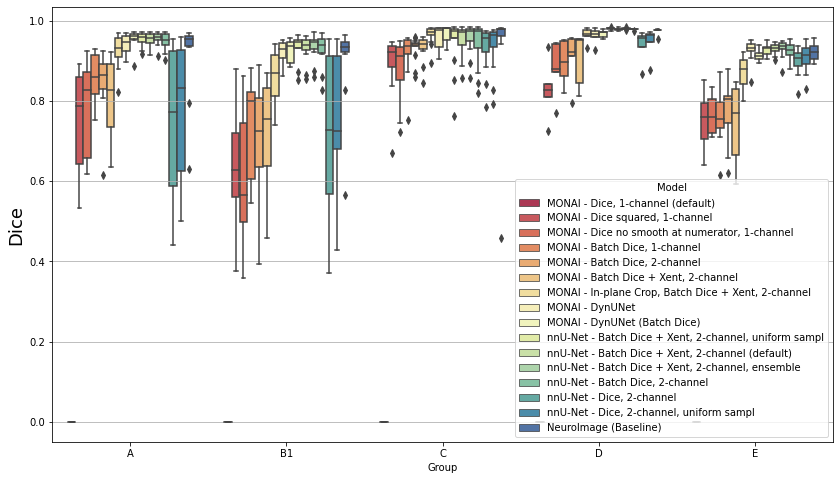

In [6]:
pd1 = pd.DataFrame(data={'Group': full_list['Group'], 'Dice': full_list['MONAI'], 'Model': 'MONAI - Dice, 1-channel (default)'})
pd1 = pd1.append(pd.DataFrame(data={'Group': full_list['Group'], 'Dice': full_list['MONAI_squared_pred'], 'Model': 'MONAI - Dice squared, 1-channel'}))
pd1 = pd1.append(pd.DataFrame(data={'Group': full_list['Group'], 'Dice': full_list['MONAI_nosmooth'], 'Model': 'MONAI - Dice no smooth at numerator, 1-channel'}))
pd1 = pd1.append(pd.DataFrame(data={'Group': full_list['Group'], 'Dice': full_list['MONAI_batch'], 'Model': 'MONAI - Batch Dice, 1-channel'}))
pd1 = pd1.append(pd.DataFrame(data={'Group': full_list['Group'], 'Dice': full_list['MONAI_batch_2ch'], 'Model': 'MONAI - Batch Dice, 2-channel'}))
pd1 = pd1.append(pd.DataFrame(data={'Group': full_list['Group'], 'Dice': full_list['MONAI_batch_xent_2ch'], 'Model': 'MONAI - Batch Dice + Xent, 2-channel'}))
pd1 = pd1.append(pd.DataFrame(data={'Group': full_list['Group'], 'Dice': full_list['MONAI_inplanecrop'], 'Model': 'MONAI - In-plane Crop, Batch Dice + Xent, 2-channel'}))
pd1 = pd1.append(pd.DataFrame(data={'Group': full_list['Group'], 'Dice': full_list['MONAI_dynUnet'], 'Model': 'MONAI - DynUNet'}))
pd1 = pd1.append(pd.DataFrame(data={'Group': full_list['Group'], 'Dice': full_list['MONAI_dynUnet_batch'], 'Model': 'MONAI - DynUNet (Batch Dice)'}))
pd1 = pd1.append(pd.DataFrame(data={'Group': full_list['Group'], 'Dice': full_list['nnUNet_uniform'], 'Model': 'nnU-Net - Batch Dice + Xent, 2-channel, uniform sampl'}))
pd1 = pd1.append(pd.DataFrame(data={'Group': full_list['Group'], 'Dice': full_list['nnUNet'], 'Model': 'nnU-Net - Batch Dice + Xent, 2-channel (default)'}))
pd1 = pd1.append(pd.DataFrame(data={'Group': full_list['Group'], 'Dice': full_list['nnUNet_ensemble'], 'Model': 'nnU-Net - Batch Dice + Xent, 2-channel, ensemble'}))
pd1 = pd1.append(pd.DataFrame(data={'Group': full_list['Group'], 'Dice': full_list['nnUNet_batchonly'], 'Model': 'nnU-Net - Batch Dice, 2-channel'}))
pd1 = pd1.append(pd.DataFrame(data={'Group': full_list['Group'], 'Dice': full_list['nnUNet_trueDice'], 'Model': 'nnU-Net - Dice, 2-channel'}))
pd1 = pd1.append(pd.DataFrame(data={'Group': full_list['Group'], 'Dice': full_list['nnUNet_trueDice_uniform'], 'Model': 'nnU-Net - Dice, 2-channel, uniform sampl'}))
pd1 = pd1.append(pd.DataFrame(data={'Group': full_list['Group'], 'Dice': full_list['NeuroImage'], 'Model': 'NeuroImage (Baseline)'}))

fig = plt.figure(figsize=(14, 8))
b1 = sns.boxplot(x='Group', y='Dice', hue='Model', data=pd1, palette="Spectral")
b1.set_ylabel('Dice', fontsize=18)
# b1.set_ylim([0, 1])
plt.grid(b=True,axis='y')

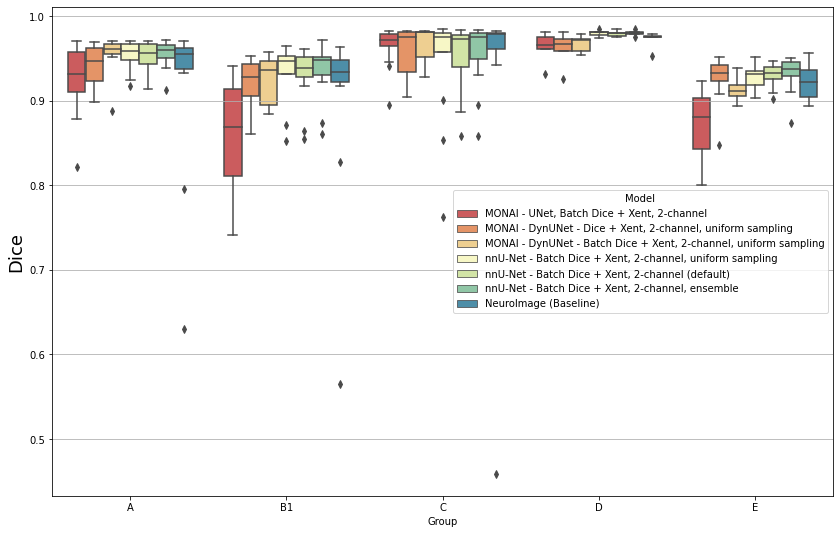

In [11]:
pd2 = pd.DataFrame(data={'Group': full_list['Group'], 'Dice': full_list['MONAI_inplanecrop'], 'Model': 'MONAI - UNet, Batch Dice + Xent, 2-channel'})
pd2 = pd2.append(pd.DataFrame(data={'Group': full_list['Group'], 'Dice': full_list['MONAI_dynUnet'], 'Model': 'MONAI - DynUNet - Dice + Xent, 2-channel, uniform sampling'}))
pd2 = pd2.append(pd.DataFrame(data={'Group': full_list['Group'], 'Dice': full_list['MONAI_dynUnet_batch'], 'Model': 'MONAI - DynUNet - Batch Dice + Xent, 2-channel, uniform sampling'}))
pd2 = pd2.append(pd.DataFrame(data={'Group': full_list['Group'], 'Dice': full_list['nnUNet_uniform'], 'Model': 'nnU-Net - Batch Dice + Xent, 2-channel, uniform sampling'}))
pd2 = pd2.append(pd.DataFrame(data={'Group': full_list['Group'], 'Dice': full_list['nnUNet'], 'Model': 'nnU-Net - Batch Dice + Xent, 2-channel (default)'}))
pd2 = pd2.append(pd.DataFrame(data={'Group': full_list['Group'], 'Dice': full_list['nnUNet_ensemble'], 'Model': 'nnU-Net - Batch Dice + Xent, 2-channel, ensemble'}))
pd2 = pd2.append(pd.DataFrame(data={'Group': full_list['Group'], 'Dice': full_list['NeuroImage'], 'Model': 'NeuroImage (Baseline)'}))

fig = plt.figure(figsize=(14, 9))
b2 = sns.boxplot(x='Group', y='Dice', hue='Model', data=pd2, palette="Spectral")
b2.set_ylabel('Dice', fontsize=18)
# b1.set_ylim([0, 1])
plt.grid(b=True,axis='y')

In [8]:
label_file = "/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset/GroupA/a04_02_Label.nii.gz"
prediction_file = monai_squared_root[0] + "/a04_02_Image/" + "a04_02_Image_seg.nii.gz"
print(label_file)
print(prediction_file)
label = np.squeeze(read_nifti(label_file))
prediction = np.squeeze(read_nifti(prediction_file))
prediction_bin = prediction > 0.5

/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset/GroupA/a04_02_Label.nii.gz
/mnt/data/mranzini/Desktop/GIFT-Surg/FBS_Monai/basic_unet_monai/tests_deterministic_seeds/monai0.2.0_tests/2020-09-15_16-20-33_monai0.2.0-MONAI_unet-MONAI_Dice_squared_pred/inf_on_valid_valid_key_metric=0.7912/a04_02_Image/a04_02_Image_seg.nii.gz


In [9]:
np.argwhere(prediction_bin == True)

array([[  0, 203, 238],
       [  0, 203, 239],
       [  0, 203, 240],
       ...,
       [ 39,  95, 156],
       [ 39,  95, 157],
       [ 39,  95, 158]])